In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

sys.path.append(os.path.join('../', 'utils'))

from TransformationUtils import ExcelYAMLHandler, StrategyCSVHandler
from GeneralUtils import GeneralUtils

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
g_utils = GeneralUtils()

In [4]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_project = dir_cur.parent
dir_data = dir_cur.joinpath("data")
dir_config = dir_cur.joinpath("config_files")
dir_transformations = dir_cur.joinpath("transformations")
dir_utils = dir_project.joinpath("utils")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_utils.joinpath("strategy_mapping.yaml")

In [ ]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "croatia_config.yaml")
config_params = g_utils.get_yaml_values(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']


Country Name: croatia
SSP Input File Name: updated_croatia_input_data_20250117_1831.csv
SSP Transformation CW: ssp_croatia_transformation_2025_01_20.xlsx


In [6]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [7]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [8]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [9]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df1(example) but not in df2(yours): {'ef_enfu_combustion_tonne_co2_per_tj_fuel_nuclear', 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_tonne_n2o_per_tj', 'nemomod_entc_input_activity_ratio_fuel_production_fp_ammonia_production_hydrogen', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_geothermal', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_wind', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_coke', 'ef_soil_ef1_n_rice_fields_n2o', 'regressionm_agrc_above_ground_residue_rice_kg_per_ha', 'ef_soil_ef2_n_drained_managed_soils_n2o_temperate_forest_nutrient_poor_kg_n2on_ha', 'frac_lndu_soil_mineral_other', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_diesel', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_kerosene', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_oil', 'qty_soil_organic_c_stock_wet_climate_tonne_per_ha', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_coal_deposits', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_biogas', 'e

In [10]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,avgmass_lvst_animal_goats_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,8807000,70,2923,31.751466,6468,315,508,303,1.1,24,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,8807000,70,2923,31.751466,6468,315,508,303,1.1,24,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,8807000,70,2923,31.751466,6468,315,508,303,1.1,24,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,8807000,70,2923,31.751466,6468,315,508,303,1.1,24,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,8807000,70,2923,31.751466,6468,315,508,303,1.1,24,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [11]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df1(example) but not in df2(yours): set()
Columns in df2(yours) but not in df1(example): set()


In [12]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

[]


In [13]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    costa_rica
1    costa_rica
2    costa_rica
3    costa_rica
4    costa_rica
Name: region, dtype: object

In [ ]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    croatia
1    croatia
2    croatia
3    croatia
4    croatia
Name: region, dtype: object

#  Let's try building transformations using this


In [15]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [ ]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/croatia/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [17]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_data, ssp_transformation_cw)
excel_yaml_handler = ExcelYAMLHandler(excel_file=cw_file_path, yaml_directory='transformations')

In [18]:
# This creates transformation yaml files for each strategy in the excel file

# Use if its the first time you are running this
# excel_yaml_handler.process_yaml_files()

# Use if you have already created the yaml files and just want to update them so the transformations with multiple params are not overwritten
# NOTE: This is a temporary solution, we need to find a better way to handle this
excel_yaml_handler.process_yaml_files(overwrite_mult_param_transformations=False)

YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_WEM wasn't updated. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_WAM wasn't updated. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NZ wasn't updated. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml for strategy strategy_NZ wasn't updated. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_WEM wasn't updated. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_WAM wasn't updated. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_NZ wasn't updated. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml for strategy strategy_WEM wasn't updated. 

In [19]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_WEM': ['TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_STRATEGY_WEM',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_WEM',
  'TX:ENTC:DEC_LOSSES_STRATEGY_WEM',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_WEM',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_WEM',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_WEM',
  'TX:LNDU:DEC_SOC_LOSS_PASTURES_STRATEGY_WEM',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_WEM',
  'TX:LNDU:INC_SILVOPASTURE_STRATEGY_WEM',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_WEM',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_WEM',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_WEM',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_WEM',
  'TX:LVST:DEC_ENTERIC_FERMENTATION_STRATEGY_WEM',
  'TX:SCOE:DEC_DEMAND_HEAT_STRATEGY_WEM',
  'TX:SCOE:INC_EFFICIENCY_APPLIANCE_STRATEGY_WEM',
  'TX:SCOE:SHIFT_FUEL_HEAT_STRATEGY_WEM',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_WEM',
  'TX:TRDE:DEC_DEMAND_STRATEGY_WEM',
  'TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_WEM',
  'TX:TRNS:INC_EFFICIENCY_NON_ELECTRIC_STRATEGY_WEM'

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [20]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

# Uncomment for completly new strategies version
# csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WEM scenario', yaml_file_suffix='WEM')
# csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WAM scenario', yaml_file_suffix='WAM')
# csv_handler.add_strategy(strategy_group='PFLO', description='Croatia NZ scenario', yaml_file_suffix='NZ')


# Uncomment to update the strategies that are currently in the strategy_definitions file
csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WEM scenario', yaml_file_suffix='WEM', custom_id=6003, update_flag=True)
csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WAM scenario', yaml_file_suffix='WAM', custom_id=6004, update_flag=True)
csv_handler.add_strategy(strategy_group='PFLO', description='Croatia NZ scenario', yaml_file_suffix='NZ', custom_id=6005, update_flag=True)


Data saved to /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/croatia/transformations/strategy_definitions.csv
Updated row with strategy_id 6003
Data saved to /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/croatia/transformations/strategy_definitions.csv
Updated row with strategy_id 6004
Data saved to /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/croatia/transformations/strategy_definitions.csv
Updated row with strategy_id 6005


In [21]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

### We finished adding new transformation files and strategies so lets load them back

In [22]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [23]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/sisepuede_region_nbs_tony_ver/croatia/transformations initialized in 5.07 seconds


In [24]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:WEM,WEM,Croatia WEM scenario,TX:WASO:INC_ENERGY_FROM_BIOGAS_STRATEGY_WEM|TX...,0
70,6004,PFLO:WAM,WAM,Croatia WAM scenario,TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_WAM|TX:...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [25]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [26]:
country_name

'croatia'

In [27]:
# Make sure to change the regions attribute to your country name

import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-01-20 16:47:56,274 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-01-20 16:47:56,278 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-01-20 16:47:56,279 - INFO - 	Setting export engine to 'csv'.
2025-01-20 16:47:56,281 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-01-20 16:47:56,282 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-01-20 16:47:56,282 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-01-20 16:47:56,283 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-01-20 16:47:56,284 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-01-20 16:47:56,284 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-01-20 16:47:56,285 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   3919.9 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-01-20 16:49:35,758 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-01-20 16:49:35,841 - INFO - Successfully initialized SISEPUEDEModels.
2025-01-20 16:49:35,885 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/pyt

In [28]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2025-01-20 16:49:36,589 - INFO - 
***	STARTING REGION croatia	***

2025-01-20 16:49:43,808 - INFO - Trying run primary_id = 0 in region croatia
2025-01-20 16:49:43,810 - INFO - Running AFOLU model
2025-01-20 16:49:45,099 - INFO - AFOLU model run successfully completed
2025-01-20 16:49:45,101 - INFO - Running CircularEconomy model
2025-01-20 16:49:45,334 - INFO - CircularEconomy model run successfully completed
2025-01-20 16:49:45,337 - INFO - Running IPPU model
2025-01-20 16:49:45,715 - INFO - IPPU model run successfully completed
2025-01-20 16:49:45,721 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-01-20 16:49:45,817 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-01-20 16:49:46,203 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-01-20 16:49:46,205 - INFO - Running Energy model (Electricity and Fuel Production: trying

2025-20-Jan 16:49:47.838 Opened SQLite database at /home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-20-Jan 16:49:48.396 Added NEMO structure to SQLite database at /home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-20-Jan 16:50:14.282 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2025-20-Jan 16:53:31.543 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-01-20 16:53:33,038 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-20 16:53:33,922 - INFO - EnergyProduction model run successfully completed
2025-01-20 16:53:33,925 - INFO - Running Energy (Fugitive Emissions)
2025-01-20 16:53:34,190 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-20 16:53:34,192 - INFO - Appending Socioeconomic outputs
2025-01-20 16:53:34,212 - INFO - Socioeconomic outputs successfully appended.
2025-01-20 16:53:34,299 - INFO - Model run for primary_id = 0 successfully completed in 230.49 seconds (n_tries = 1).
2025-01-20 16:53:34,492 - INFO - Trying run primary_id = 69069 in region croatia
2025-01-20 16:53:34,494 - INFO - Running AFOLU model
2025-01-20 16:53:34,941 - INFO - AFOLU model run successfully 

2025-20-Jan 16:53:38.400 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-20-Jan 16:58:33.496 Finished modeling scenario.


2025-01-20 16:58:33,828 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-20 16:58:33,863 - INFO - EnergyProduction model run successfully completed
2025-01-20 16:58:33,865 - INFO - Running Energy (Fugitive Emissions)
2025-01-20 16:58:33,931 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-20 16:58:33,932 - INFO - Appending Socioeconomic outputs
2025-01-20 16:58:33,947 - INFO - Socioeconomic outputs successfully appended.
2025-01-20 16:58:33,954 - INFO - Model run for primary_id = 69069 successfully completed in 299.46 seconds (n_tries = 1).
2025-01-20 16:58:33,986 - INFO - Trying run primary_id = 70070 in region croatia
2025-01-20 16:58:33,988 - INFO - Running AFOLU model
2025-01-20 16:58:34,263 - INFO - AFOLU model run successfully completed
2025-01-20 16:58:34,264 - INFO - Running CircularEconomy model
2025-01-20 16:58:34,339 - INFO - CircularEconomy model run successfully completed
2025-01-20 16:58:34,340 - INFO - Running I

2025-20-Jan 16:58:40.489 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-20-Jan 17:04:34.560 Finished modeling scenario.


2025-01-20 17:04:35,085 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-20 17:04:35,122 - INFO - EnergyProduction model run successfully completed
2025-01-20 17:04:35,123 - INFO - Running Energy (Fugitive Emissions)
2025-01-20 17:04:35,232 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-20 17:04:35,234 - INFO - Appending Socioeconomic outputs
2025-01-20 17:04:35,255 - INFO - Socioeconomic outputs successfully appended.
2025-01-20 17:04:35,269 - INFO - Model run for primary_id = 70070 successfully completed in 361.28 seconds (n_tries = 1).
2025-01-20 17:04:35,325 - INFO - Trying run primary_id = 71071 in region croatia
2025-01-20 17:04:35,327 - INFO - Running AFOLU model
2025-01-20 17:04:35,749 - INFO - AFOLU model run successfully completed
2025-01-20 17:04:35,752 - INFO - Running CircularEconomy model
2025-01-20 17:04:35,893 - INFO - CircularEconomy model run successfully completed
2025-01-20 17:04:35,895 - INFO - Running I

2025-20-Jan 17:04:38.905 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-01-20 17:10:45,215 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable


2025-20-Jan 17:10:45.008 Solver did not find a solution for model. No results will be saved to database.
2025-20-Jan 17:10:45.047 Finished modeling scenario.


2025-01-20 17:10:45,480 - INFO - Running Energy (Fugitive Emissions)
2025-01-20 17:10:45,609 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-01-20 17:10:45,611 - INFO - Appending Socioeconomic outputs
2025-01-20 17:10:45,632 - INFO - Socioeconomic outputs successfully appended.
2025-01-20 17:10:45,656 - INFO - Model run for primary_id = 71071 successfully completed in 370.33 seconds (n_tries = 1).
2025-01-20 17:10:45,668 - INFO - 
***	 REGION croatia COMPLETE	***

2025-01-20 17:10:46,055 - INFO - Table MODEL_OUTPUT successfully written to /home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-01-20T16;47;55.357609/sisepuede_run_2025-01-20T16;47;55.357609_output_database/MODEL_OUTPUT.csv.
2025-01-20 17:10:46,069 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/python3.11/site-packages/sisepuede/out/sisepuede_r

{'croatia': [0, 69069, 70070, 71071]}

In [29]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [30]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Some testing for Croatia (you can delete this section for a new country)

In [31]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,croatia,0,128992.475401,286925.570284,59534.988647,155176.845408,200241.524314,109285.291660,144565.284932,...,860714.235864,5.781814e+06,65829.816853,279108.581486,50211.974800,175242.943363,0.0,0.0,2.050396e+06,725849.288265
1,0,croatia,1,128305.935425,285398.458926,59218.124042,154350.943684,199175.773688,108703.639735,143795.861390,...,857478.660027,5.906717e+06,52166.876709,331312.854435,70450.376552,215192.338859,2736.0,2449.0,2.713049e+06,699533.070417
2,0,croatia,2,127621.990578,283877.120067,58902.457190,153528.163879,198114.051612,108124.186462,143029.346278,...,660924.245615,5.951148e+06,38967.956801,296921.771405,82224.830575,210243.344677,2736.0,2449.0,2.331104e+06,761148.281366
3,0,croatia,3,126940.639041,282361.549661,58587.987250,152708.503803,197056.355263,107546.930298,142265.737557,...,957822.768981,5.919376e+06,17239.772927,378730.362142,93529.211867,213539.618942,2736.0,2449.0,2.111415e+06,729155.981592
4,0,croatia,4,126261.879236,280851.744198,58274.713494,151891.961560,196002.682190,106971.869908,141505.033460,...,892950.504956,5.887725e+06,21001.252360,359927.486275,85408.876964,264501.812874,2736.0,2449.0,2.234268e+06,737682.556359


In [32]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
0,1.778561,0.0,5.926638,0.646299,-1.120523,2.820493,7.411204,0.685409,0.208897,1.938988,...,1.201673,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.815514,0.0,6.295740,0.674630,-1.117405,2.881019,7.362391,0.691509,0.211356,1.963912,...,1.261884,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.760145,0.0,3.670505,0.488635,-1.115956,2.928994,7.537865,0.697343,0.213751,1.988409,...,1.327061,0.000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.715973,0.0,5.594996,0.712298,-1.114894,2.965038,7.389217,0.702919,0.216042,2.012429,...,1.402215,0.000036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.725050,0.0,6.284109,0.801042,-1.114216,3.092591,7.299132,0.708244,0.218235,2.035987,...,1.487724,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
139,1.494007,-12.841314,NaN,NaN,-1.821024,0.534996,2.671432,0.780203,0.336996,1.206899,...,7.539120,0.000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,1.486015,-13.517172,NaN,NaN,-1.829362,0.413028,2.381316,0.780932,0.336897,1.132254,...,7.684384,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,1.478061,-14.193031,NaN,NaN,-1.836671,0.295228,2.091693,0.781564,0.336193,1.055981,...,7.823886,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,1.470144,-14.868890,NaN,NaN,-1.843246,0.181565,1.802677,0.782103,0.334877,0.978176,...,7.956041,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,1.462265,-15.544748,NaN,NaN,-1.848958,0.072274,1.514450,0.782550,0.333245,0.899952,...,8.081548,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
cement_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_cement_tonne' in col]]
cement_df['year'] = cement_df['time_period'] + 2015
cement_df[cement_df.primary_id == 0]

,primary_id,time_period,prod_ippu_cement_tonne,year
0,0,0,2.947083e+06,2015
1,0,1,2.973434e+06,2016
2,0,2,2.999586e+06,2017
3,0,3,3.025544e+06,2018
4,0,4,3.051312e+06,2019
5,0,5,3.076895e+06,2020
6,0,6,3.292930e+06,2021
7,0,7,3.417513e+06,2022
8,0,8,3.473832e+06,2023
9,0,9,3.543734e+06,2024


In [35]:
mining_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_mining_tonne' in col]]
mining_df['year'] = mining_df['time_period'] + 2015
mining_df[mining_df.primary_id == 0]

,primary_id,time_period,prod_ippu_mining_tonne,year
0,0,0,2.549692e+06,2015
1,0,1,2.572490e+06,2016
2,0,2,2.595115e+06,2017
3,0,3,2.617573e+06,2018
4,0,4,2.639866e+06,2019
5,0,5,2.662000e+06,2020
6,0,6,2.848904e+06,2021
7,0,7,2.956688e+06,2022
8,0,8,3.005413e+06,2023
9,0,9,3.065889e+06,2024


In [36]:
df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.0

In [37]:
df_in['lndu_reallocation_factor'].mean()

0.0

In [38]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'].head()

0    0.538387
1    0.538387
2    0.538387
3    0.538387
4    0.538387
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [39]:
df_in[['primary_id', 'time_period', 'elasticity_ippu_cement_production_to_gdp']].head()

,primary_id,time_period,elasticity_ippu_cement_production_to_gdp
0,0,0,0.538387
1,0,1,0.538387
2,0,2,0.538387
3,0,3,0.538387
4,0,4,0.538387


In [40]:
[col for col in df_out.columns if 'lvst' in col]

['demand_lvst_buffalo',
 'demand_lvst_cattle_dairy',
 'demand_lvst_cattle_nondairy',
 'demand_lvst_chickens',
 'demand_lvst_goats',
 'demand_lvst_horses',
 'demand_lvst_mules',
 'demand_lvst_pigs',
 'demand_lvst_sheep',
 'emission_co2e_ch4_lvst_entferm_buffalo',
 'emission_co2e_ch4_lvst_entferm_cattle_dairy',
 'emission_co2e_ch4_lvst_entferm_cattle_nondairy',
 'emission_co2e_ch4_lvst_entferm_chickens',
 'emission_co2e_ch4_lvst_entferm_goats',
 'emission_co2e_ch4_lvst_entferm_horses',
 'emission_co2e_ch4_lvst_entferm_mules',
 'emission_co2e_ch4_lvst_entferm_pigs',
 'emission_co2e_ch4_lvst_entferm_sheep',
 'emission_co2e_subsector_total_lvst',
 'exportsadj_lvst_buffalo',
 'exportsadj_lvst_cattle_dairy',
 'exportsadj_lvst_cattle_nondairy',
 'exportsadj_lvst_chickens',
 'exportsadj_lvst_goats',
 'exportsadj_lvst_horses',
 'exportsadj_lvst_mules',
 'exportsadj_lvst_pigs',
 'exportsadj_lvst_sheep',
 'importssadj_lvst_buffalo',
 'importssadj_lvst_cattle_dairy',
 'importssadj_lvst_cattle_nonda

In [41]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'demand_lvst' in col]].head(36)

,primary_id,time_period,demand_lvst_buffalo,demand_lvst_cattle_dairy,demand_lvst_cattle_nondairy,demand_lvst_chickens,demand_lvst_goats,demand_lvst_horses,demand_lvst_mules,demand_lvst_pigs,demand_lvst_sheep
0,0,0,0.0,489423.870645,517401.776469,1.362735e+07,70312.253032,23970.740345,1717.104435,1.491565e+06,756168.693324
1,0,1,0.0,489562.600384,519389.440967,1.375384e+07,70627.274002,24079.067530,1724.942463,1.497293e+06,759548.316311
2,0,2,0.0,489180.290525,520891.512974,1.387148e+07,70876.711080,24163.278740,1731.517915,1.501621e+06,762241.394242
3,0,3,0.0,487442.592788,521200.045097,1.396906e+07,70973.086918,24196.005314,1734.305641,1.502512e+06,763264.821385
4,0,4,0.0,484479.388303,520404.567523,1.404737e+07,70922.599502,24180.142027,1733.043066,1.500218e+06,762734.947108
5,0,5,0.0,483377.914075,521121.103227,1.414775e+07,71068.462756,24228.910843,1735.830792,1.502284e+06,764300.820916
6,0,6,0.0,492346.104699,542519.585162,1.523634e+07,74287.352823,25325.224937,1814.574243,1.563975e+06,798912.704858
7,0,7,0.0,496234.446932,553505.210987,1.584733e+07,75966.780238,25898.766392,1855.339832,1.595642e+06,816962.366569
8,0,8,0.0,498082.601199,558464.548638,1.612390e+07,76723.139710,26156.936890,1874.066189,1.609940e+06,825105.670797
9,0,9,0.0,500679.314274,564816.369086,1.646981e+07,77687.646830,26485.813223,1897.367997,1.628249e+06,835479.238494


In [42]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'pop_lvst' in col]].head(37)

,primary_id,time_period,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,0,0,440091,440091,10167999,61999,21867,2458,1166887,607710
1,0,1,0,445833,445833,10261450,62809,22153,2491,1171363,615639
2,0,2,0,451485,451485,10348361,63605,22433,2523,1174745,623443
3,0,3,0,457048,457048,10420458,64389,22710,2554,1175442,631125
4,0,4,0,462524,462524,10478315,65160,22982,2584,1173649,638687
5,0,5,0,467914,467914,10552476,65919,23250,2614,1175263,646130
6,0,6,0,473220,473220,11356731,66667,23513,2644,1223469,653457
7,0,7,0,478443,478443,11808139,67403,23773,2673,1248214,660669
8,0,8,0,483584,483584,12012469,68127,24028,2702,1259387,667769
9,0,9,0,488646,488646,12268035,68840,24280,2730,1273693,674758


In [43]:
df_in[ 'elasticity_protein_in_diet_to_gdppc']

0      0.195
1      0.195
2      0.195
3      0.195
4      0.195
       ...  
139    0.195
140    0.195
141    0.195
142    0.195
143    0.195
Name: elasticity_protein_in_diet_to_gdppc, Length: 144, dtype: float64

In [44]:
df_in['frac_gnrl_eating_red_meat']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
139    1.0
140    1.0
141    1.0
142    1.0
143    1.0
Name: frac_gnrl_eating_red_meat, Length: 144, dtype: float64

In [45]:
df_in[df_in.time_period == 5][['time_period'] + [col for col in df_in.columns if 'pop_lvst' in col]].head(6)

,time_period,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
5,5,0.0,423000.0,423000.0,11989000.0,86000.0,23649.0,3252.0,1033000.0,662000.0
41,5,0.0,423000.0,423000.0,11989000.0,86000.0,23649.0,3252.0,1033000.0,662000.0
77,5,0.0,423000.0,423000.0,11989000.0,86000.0,23649.0,3252.0,1033000.0,662000.0
113,5,0.0,423000.0,423000.0,11989000.0,86000.0,23649.0,3252.0,1033000.0,662000.0


In [46]:
df_in[df_in.primary_id == 0][['frac_waso_non_recycled_incinerated', 'frac_waso_non_recycled_landfilled', 'frac_waso_non_recycled_open_dump']].head()

,frac_waso_non_recycled_incinerated,frac_waso_non_recycled_landfilled,frac_waso_non_recycled_open_dump
0,0.18,0.8,0.02
1,0.18,0.8,0.02
2,0.18,0.8,0.02
3,0.18,0.8,0.02
4,0.18,0.8,0.02


In [47]:
df_qty_open_dump = df_out[[col for col in df_out.columns if 'qty_waso_open_dump' in col]]
df_qty_open_dump

,qty_waso_open_dump_chemical_industrial_tonne,qty_waso_open_dump_food_tonne,qty_waso_open_dump_glass_tonne,qty_waso_open_dump_metal_tonne,qty_waso_open_dump_nappies_tonne,qty_waso_open_dump_other_tonne,qty_waso_open_dump_paper_tonne,qty_waso_open_dump_plastic_tonne,qty_waso_open_dump_rubber_leather_tonne,qty_waso_open_dump_sludge_tonne,qty_waso_open_dump_textiles_tonne,qty_waso_open_dump_wood_tonne,qty_waso_open_dump_yard_tonne
0,20564.637503,22592.505387,722.866579,410.275626,667.086542,8160.856225,4532.568817,4473.958013,529.637961,674.996992,449.349495,902.815954,1613.165353
1,20892.201330,22568.554344,722.011207,409.790145,664.621697,8282.843770,4535.743527,4468.663957,529.011237,674.285686,447.689175,900.046989,1608.217724
2,21218.978377,22520.848738,720.388979,408.869421,661.384793,8404.059256,4534.477103,4458.623683,527.822646,672.876992,445.508797,896.253808,1601.440010
3,21543.550384,22408.455499,716.679090,406.763808,655.997094,8523.123946,4521.315067,4435.662474,525.104442,669.574596,441.879643,889.624194,1589.594115
4,21866.185164,22238.449239,711.109691,403.602797,648.714522,8640.293764,4497.472765,4401.192409,521.023793,664.595110,436.974102,880.488707,1573.270687
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,7563.605617,555.672870,29.300394,16.629953,102.738928,2913.708194,199.780594,181.345681,21.468140,33.110930,16.279206,33.640770,44.440775
140,5740.502664,308.475115,18.186463,10.322046,76.783799,2210.657530,124.182447,112.559459,13.325061,18.986887,10.084717,20.850077,24.922332
141,3871.181608,135.281386,9.605715,5.451892,51.008927,1490.305144,65.683693,59.451586,7.038022,8.598882,5.316461,10.996952,11.042815
142,1957.037782,33.365300,3.547403,2.013391,25.414276,753.176961,24.290468,21.955550,2.599151,2.189577,1.959772,4.055598,2.752206


In [48]:
df_qty_open_dump.head(15).sum(axis=1)

0     66294.720447
1     66703.680787
2     67071.532601
3     67327.324352
4     67483.372750
5     67802.011790
6     72088.601104
7     74599.161303
8     75781.575360
9     77299.235874
10    78447.751802
11    79547.618793
12    80730.880376
13    81931.551514
14    83027.545675
dtype: float64

In [49]:
df_out[df_out.isna().any(axis=1)]

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
108,71071,croatia,0,128992.475401,286925.570284,59534.988647,155176.845408,200241.524314,109285.291660,144565.284932,...,860714.235864,5.781814e+06,65829.816853,279108.581486,50211.974800,175242.943363,0.000000,0.000000,2.050396e+06,725849.288265
109,71071,croatia,1,128305.935425,285398.458926,59218.124042,154350.943684,199175.773688,108703.639735,143795.861390,...,857478.660027,5.906717e+06,52166.876709,331312.854435,70450.376552,215192.338859,2736.000000,2449.000000,2.713049e+06,699533.070417
110,71071,croatia,2,127621.990578,283877.120067,58902.457190,153528.163879,198114.051612,108124.186462,143029.346278,...,660924.245615,5.951148e+06,38967.956801,296921.771405,82224.830575,210243.344677,2736.000000,2449.000000,2.331104e+06,761148.281366
111,71071,croatia,3,126940.639041,282361.549661,58587.987250,152708.503803,197056.355263,107546.930298,142265.737557,...,957822.768981,5.919376e+06,17239.772927,378730.362142,93529.211867,213539.618942,2736.000000,2449.000000,2.111415e+06,729155.981592
112,71071,croatia,4,126261.879236,280851.744198,58274.713494,151891.961560,196002.682190,106971.869908,141505.033460,...,892950.504956,5.887725e+06,21001.252360,359927.486275,85408.876964,264501.812874,2736.000000,2449.000000,2.234268e+06,737682.556359
113,71071,croatia,5,125585.709808,279347.700663,57962.635296,151078.535517,194953.030290,106399.004143,140747.232467,...,888168.492874,5.856194e+06,20888.784488,357999.968928,84951.487356,263085.328021,2736.000000,2449.000000,2.222303e+06,733732.049721
114,71071,croatia,6,124912.129604,277849.416491,57651.752125,150268.224289,193907.397772,105828.332026,139992.333285,...,883404.792326,5.824784e+06,20776.747285,356079.832533,84495.849208,261674.267246,2736.000000,2449.000000,2.210384e+06,729796.670572
115,71071,croatia,7,124241.137657,276356.889531,57342.063534,149461.026711,192865.783136,105259.852737,139240.334831,...,878659.396471,5.793495e+06,20665.140589,354167.074332,84041.961867,260268.628525,2736.000000,2449.000000,2.198510e+06,725876.413261
116,71071,croatia,8,123572.733166,274870.118005,57033.569154,148656.941822,191828.185140,104693.565599,138491.236209,...,873932.299657,5.762327e+06,20553.964266,352261.692047,83589.824791,258868.410181,2736.000000,2449.000000,2.186683e+06,721971.273119
117,71071,croatia,9,122906.915486,273389.100472,56726.268686,147855.968843,190794.602779,104129.470065,137745.036693,...,869223.497306,5.731279e+06,20443.218210,350363.683832,83139.437543,257473.610860,2736.000000,2449.000000,2.174901e+06,718081.246363


In [50]:
df_in[[col for col in df_in.columns if 'frac_waso_recycled' in col]]

,frac_waso_recycled_glass,frac_waso_recycled_metal,frac_waso_recycled_paper,frac_waso_recycled_plastic,frac_waso_recycled_rubber_leather,frac_waso_recycled_textiles,frac_waso_recycled_wood
0,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400
1,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400
2,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400
3,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400
4,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400,0.326400
...,...,...,...,...,...,...,...
139,0.841548,0.841548,0.841548,0.841548,0.841548,0.841548,0.841548
140,0.868661,0.868661,0.868661,0.868661,0.868661,0.868661,0.868661
141,0.895774,0.895774,0.895774,0.895774,0.895774,0.895774,0.895774
142,0.922887,0.922887,0.922887,0.922887,0.922887,0.922887,0.922887


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [51]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

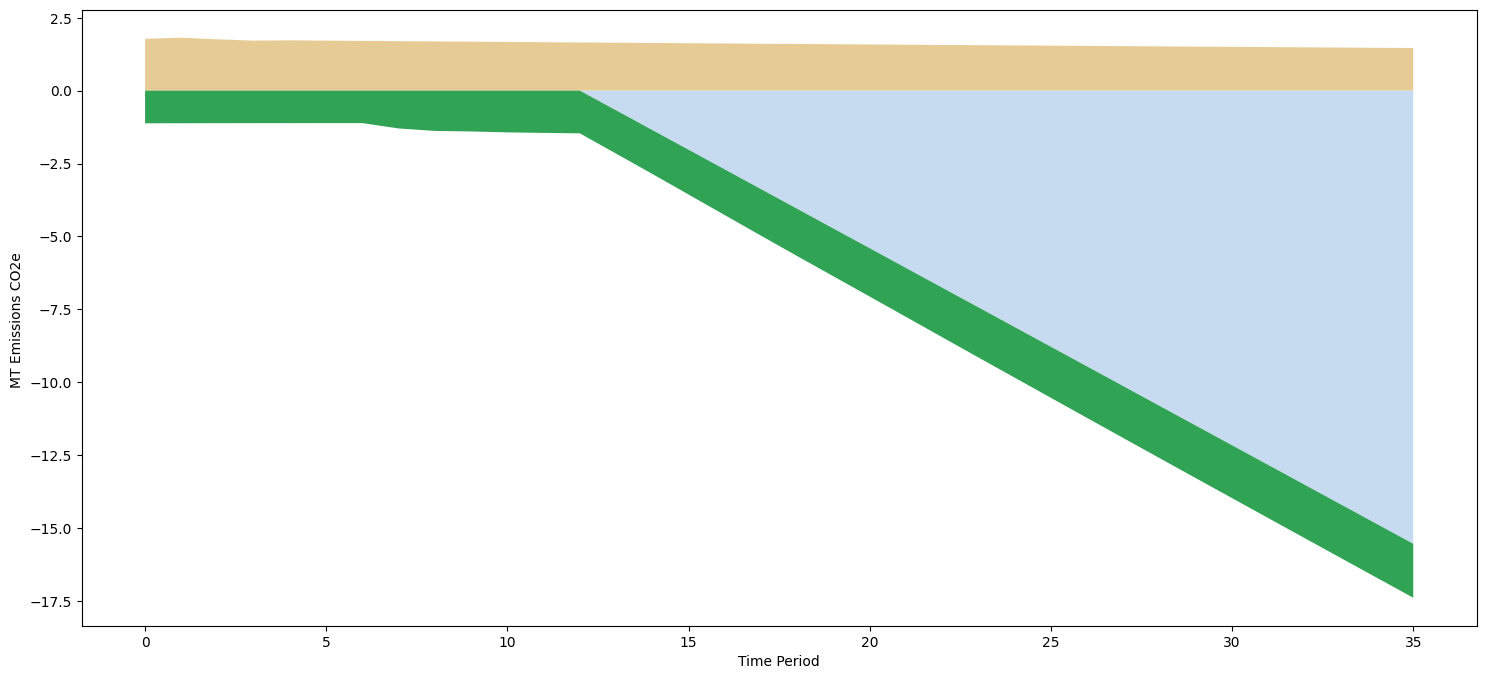

In [52]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)


# Export Wide File (Last Mandatory Step)

In [53]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [54]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/ssp-data-env-2/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [56]:
# primary_id = 0

# df_prim = df_out[
#     df_out[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]

# df_in_cur = df_in[
#     df_in[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]


# fields_plot = [
#     x for x in df_prim.columns
#     if "investment" in x
#     and df_prim[x].max() > 0
# ]
# (
#     df_prim[fields_plot]
#     .plot(
#         legend = True,
#     )
# )




In [57]:


# fig, ax = plt.subplots(figsize = (15, 10))
# df_resid = matt.extract_model_variable(
#     df_in_cur,
#     "NemoMod ResidualCapacity"
# )
# (
#     df_resid
#     .plot
#     .area(
#         ax = ax
#     )
# )

In [58]:
# df_resid

In [59]:
# [x for x in df_out.columns if "capacity" in x]

In [60]:
# ssp.model_attributes.configuration.dict_config


In [61]:
# modvar = matt.get_variable("NemoMod Generation Capacity")
# modvar.get_from_dataframe(df_prim).head()

In [62]:
# #[x for x in matt.all_variables if "Consumption" in x]
# [x for x in matt.all_variables if "Production" in x]
# modvar = matt.get_variable("NemoMod Production by Technology")


# unit = matt.get_unit("energy")
# (modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [63]:
# df_inputs

In [64]:
# modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
# matt.extract_model_variable(
#     df_prim,
#     modvar
# )